## 볼린저밴드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock

import time
from functools import wraps
from xml.etree import ElementTree

import pandas as pd
import numpy as np
from datetime import datetime, date
from pykrx import stock

import FinanceDataReader as fdr

In [2]:
def myplot(df, nrows=5,  kind='line', title='제목', labels=False):  
    if nrows > 0:
        print(df.head(nrows))
    else:
        print(df.tail(nrows))
    
    if labels:
        cols = df.columns
        for i, col in enumerate(cols):
            df[col].plot(label=labels[i], kind=kind)
    else :
        df.plot(kind=kind)
    
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
def myplotmix(df1, df2, y1='ylabel-1', y2='ylabel-2', kind1='bar', kind2='line', title='제목',  nrows1=5, nrows2=5,  labels=False):  
    ytl=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    if nrows1 > 0:
        print(df1.head(nrows1))
    elif nrows1 < 0:
        print(df1.tail(nrows1))
    if nrows2 > 0:
        print(df2.head(nrows2))
    else:
        print(df2.tail(nrows2))
    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax2=ax1.twinx()
    if kind1 == 'line':
        df1.plot(kind=kind1, ax=ax2, marker='d',color='#e35f62')  #color='y', 
        df2.plot(kind=kind2, ax=ax1)  #bar
    else:
        df1.plot(kind=kind1, ax=ax1,color='#bcbd22')
        df2.plot(kind=kind2, ax=ax2) #color='y',
        
    # df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    # ax1.set_xticklabels(df['date'])    
    ax1.yaxis.tick_right()
    ax2.yaxis.tick_left()
    ax1.set_ylabel(y1) #, color='red')
    ax2.set_ylabel(y2) #, color='red')
    ax1.legend(loc=1)
    ax2.legend(loc=2)
    plt.title(title)
    ax1.grid(False)
    ax2.grid(False)
    plt.show()

In [4]:
# def my_ticker(*names):    
#     df_code = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
#     df_code.종목코드 = df_code.종목코드.map('{:06d}'.format)
#     df_code = df_code[['회사명', '종목코드']]
#     code_list = []
#     for name in names:
#         code = df_code.query("회사명=='{}'".format(name))['종목코드'].to_string(index=False)
#         code_list.append(code)
#     return code_list
# #     return code.strip()
# my_ticker('삼성전자','현대자동차')

In [5]:
def my_ticker(names):    
    df_code = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
    df_code.종목코드 = df_code.종목코드.map('{:06d}'.format)

    df_code = df_code[['회사명', '종목코드']]
    code_list = []
    for name in names:
        code = df_code.query("회사명=='{}'".format(name))['종목코드'].to_string(index=False)
        code_list.append(code)
    return code_list

# stocks = my_ticker(['삼성전자', 'SK하이닉스', '현대자동차', 'NAVER'])
# print(stocks)

In [6]:
# def logger(func):
#     @wraps(func)
#     def wrapper(*args, **kwargs):
#         start = time.perf_counter()
#         success, failed = func(*args, **kwargs)
#         end = time.perf_counter() - start
#         func_start, func_end = args[0], args[1]
#         print(#f'#date: {func_start} ~ {func_end}, \n',
#               f'#success: {success} item(s), \n',
#               f'#failed: {failed} item(s), \n',
#              )
#     return wrapper
# @logger
def my_krx(start, end, *codes):
    error_list = []
    failed = 0
    success = 0
    for code in codes:
        try:
            df = stock.get_market_ohlcv_by_date(start, end, code)
            df.reset_index(inplace=True)
            df.insert(loc=1, column='종목코드', value=code)
            df.columns = ['date', 'code', 'open', 'high', 'low', 'close','volume']
            success += 1
        except ElementTree.ParseError as e:
            error_list.append(e)
            drop_rows(database, table, code)  # 특정 종목코드에서 에러 발생 시 해당 종목코드에 대한 데이터 삭제 후 다음 종목코드로 넘어감
            failed += 1
            continue
        except Exception as e:
            print('Error occurred : ', e)
            failed += 1
            continue
    print(f'success:{success}, failed:{failed}')
    return df

In [7]:
df = pd.DataFrame()
df = my_krx('20181203', '20210427', '005930')
df.head()

success:1, failed:0


,date,code,open,high,low,close,volume
0,2018-12-03,005930,42750,43400,42400,43250,12110702
1,2018-12-04,005930,42650,42900,41900,42150,14347746
2,2018-12-05,005930,40900,41750,40850,41450,12631983
3,2018-12-06,005930,40600,41100,40450,40500,14251826
4,2018-12-07,005930,40900,41400,40850,40950,11433083


## 볼린저밴드
* 20일 이동평균선을 이용한 매수 매도 진입점 파악

* 상한선 : 볼리저밴드   + 2편차
* 볼린저밴드 = 20일 이평선 / 편차
* 하한선 : 볼리저밴드   - 2편차

In [8]:
df['m20'] = df['close'].rolling(20).mean()
df['m20_std'] = df['close'].rolling(20).std()
df['upper'] = df['m20'] + (df['m20_std'] * 2)
df['lower'] = df['m20'] - (df['m20_std'] * 2)


In [9]:
df.dropna(axis=0, inplace=True)

In [10]:
# df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [11]:
df.head()

,code,open,high,low,close,volume,m20,m20_std,upper,lower
date,,,,,,,,,,
2019-01-02,005930,39400,39400,38550,38750,7847664,39772.5,1370.312584,42513.125169,37031.874831
2019-01-03,005930,38300,38550,37450,37600,12471493,39490.0,1185.615541,41861.231082,37118.768918
2019-01-04,005930,37450,37600,36850,37450,14108958,39255.0,1092.787358,41440.574717,37069.425283
2019-01-07,005930,38000,38900,37800,38750,12748997,39120.0,966.872331,41053.744663,37186.255337
2019-01-08,005930,38000,39200,37950,38100,12756554,39000.0,934.992260,40869.984520,37130.015480


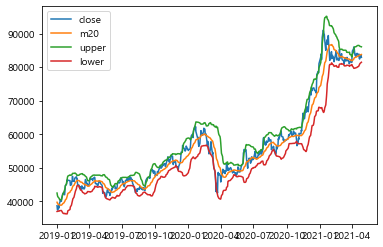

In [12]:
plt.plot(df['close'], label='close')
plt.plot(df['m20'], label='m20')
plt.plot(df['upper'], label='upper')
plt.plot(df['lower'], label='lower')
plt.legend()

## 주가 데이터 주기 설정

In [13]:
SIZE_ = 100

In [14]:
df.iloc[:SIZE_].index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17',
               '2019-01-18', '2019-01-21', '2019-01-22', '2019-01-23',
               '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29',
               '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-07',
               '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-04',
               '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08',
               '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14',
               '2019-03-15', '2019-03-18'],
              dtype='datetime64[ns]', name='date', freq=None)

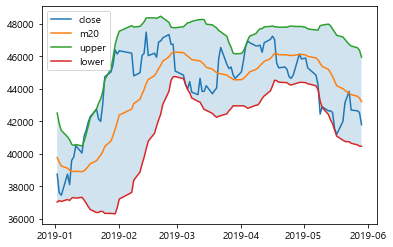

In [15]:
plt.plot(df['close'].iloc[:SIZE_], label='close')
plt.plot(df['m20'].iloc[:SIZE_], label='m20')
plt.plot(df['upper'].iloc[:SIZE_], label='upper')
plt.plot(df['lower'].iloc[:SIZE_], label='lower')
# plt.fill_between(df['upper'], df['lower'], color='#cccccc')
plt.fill_between(df.iloc[:SIZE_].index, df['upper'].iloc[:SIZE_], df['lower'].iloc[:SIZE_], alpha=0.2)
plt.legend()

### 1.  %b 지표
* %b : 주가가 볼린저 밴드 영역 내 어느곳에 위치해 있는지를 나타내는 지표
* %b =  (종가-하한볼린저) / (상한볼린저 - 하한볼린저)

In [16]:
df['b%'] = (df['close'].iloc[:SIZE_] -  df['lower'].iloc[:SIZE_]) / (df['upper'].iloc[:SIZE_] - df['lower'].iloc[:SIZE_])

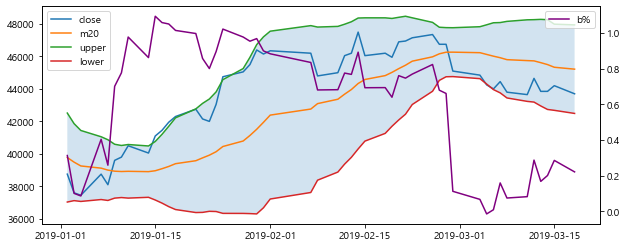

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(df['close'].iloc[:50], label = 'close')
plt.plot(df['m20'].iloc[:50], label= 'm20')
plt.plot(df['upper'].iloc[:50], label='upper')
plt.plot(df['lower'].iloc[:50], label= 'lower')
plt.fill_between(df.iloc[:50].index, df['upper'].iloc[:50], df['lower'].iloc[:50], alpha =0.2)
plt.legend()

plt.twinx()
plt.plot(df['b%'].iloc[:50],label = 'b%' , color = 'purple')
plt.legend()
plt.show()


* %b 수치는 주가의 흐름을 따른다

### 2. 밴드폭
* 스퀴즈 파악에 유용
* 주가가 극도로 떨어져 이제 곧 반등세(상승세)를 보일 것으로 예상되는 상황
* 밴드폭 = (상한 - 하한) / 중간(-->이평선) # * 100

In [18]:
df["bwith"] = (df['upper']- df['lower']) / df['m20'] *100

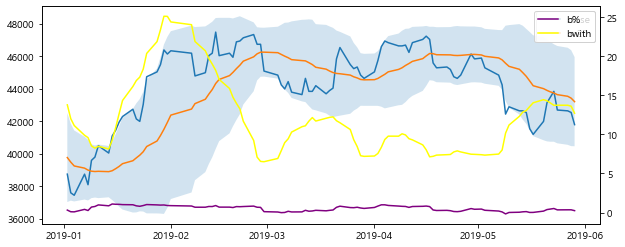

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(df['close'].iloc[:SIZE_], label = 'close')
plt.plot(df['m20'].iloc[:SIZE_], label= 'm20')
# plt.plot(df['upper'].iloc[:SIZE_], label='upper')
# plt.plot(df['lower'].iloc[:SIZE_], label= 'lower')
plt.fill_between(df.iloc[:SIZE_].index, df['upper'].iloc[:SIZE_], df['lower'].iloc[:SIZE_], alpha =0.2)
plt.legend()

plt.twinx()
plt.plot(df['b%'].iloc[:SIZE_],label = 'b%' , color = 'purple')
plt.plot(df['bwith'].iloc[:SIZE_],label = 'bwith' , color = 'yellow')
plt.legend()
plt.show()

* 변동성이 크다 = 밴드폭이 크다
* 밴드폭 최상 == lower 최하

* 일중강도지표(RSI) , 현금흐름지표(MFI)

## 볼린저밴드 매매 전략
* 변동성 돌파
* 추세 추종  : 추세가 상승세일때 매수, 하락세 일때 매도
* 반전 : 주가가 반등세(반등) 구간을 찾아내 매수 매도

* 추세추종 : 현금흐름지수(MoneyFlowIndex)를 따른다
* MFI : 중심가격(고,저,종 /3) , 
* RSI : 중심가격 * 거래량
* MFI = 100 -  (  100 /  1 + (긍정현금흐름 / 부정현금흐름)  )
  - 긍정현금흐름 : 중심가가 전날보다 상승한 날들의 합
  - 부정현금흐름 : 중심가가 전날보다 하락한 날들의 합

In [20]:
df['mp'] = (df['high'] + df['low'] + df['close'] ) / 3
df['pos_mf'] = 0 #긍정현금흐름
df['neg_mf'] = 0 #부정현금흐름
for d in range(len(df) -1):
    #d:어제  d+1:오늘
    if df['mp'].values[d] < df['mp'].values[d+1]:   #어제평균가 < 오늘평균가
        #긍정현금흐름++   
        # 시고저3 가 어제보다 올랐다 --> (시고저3*거래량) 
        df['pos_mf'].values[d+1] = df['mp'].values[d+1] * df['volume'].values[d+1]
        df['neg_mf'].values[d+1] = 0
    else:
        #부정현금흐름++
        df['neg_mf'].values[d+1] = df['mp'].values[d+1] * df['volume'].values[d+1]
        df['pos_mf'].values[d+1] = 0

# MFI = 100 - ( 100 / 1 + (긍정현금흐름합 / 부정현금흐름합) )
df['MFI']   = 100 - ( 100 / ( 1 + (df['pos_mf'].sum() / df['neg_mf'].sum())) )
df['MFI10'] = 100 - ( 100 / ( 1 + (df['pos_mf'].rolling(10).sum() / df['neg_mf'].rolling(10).sum()))  )

In [21]:
import matplotlib.font_manager as fm
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

In [33]:
df["b%"]

date
2019-01-02    0.313455
2019-01-03    0.101473
2019-01-04    0.087065
2019-01-07    0.404331
2019-01-08    0.259356
                ...   
2021-04-21         NaN
2021-04-22         NaN
2021-04-23         NaN
2021-04-26         NaN
2021-04-27         NaN
Name: b%, Length: 573, dtype: float64

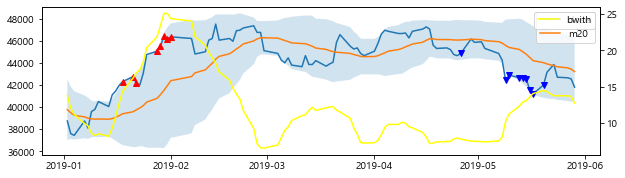

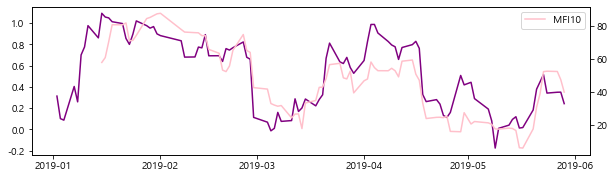

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.subplot(2,1,1)
plt.plot(df['close'].iloc[:SIZE_], label = 'close')
plt.plot(df['m20'].iloc[:SIZE_], label= 'm20')
# plt.plot(df['upper'].iloc[:SIZE_], label='upper')
# plt.plot(df['lower'].iloc[:SIZE_], label= 'lower')
plt.fill_between(df.iloc[:SIZE_].index, df['upper'].iloc[:SIZE_], df['lower'].iloc[:SIZE_], alpha =0.2)

for i in range(len(df[:SIZE_])):
    if df["MFI10"].values[i] >= 80 and df["b%"].values[i] >= 0.8 :  #앞으로 오를거야-->매수(지금사)
        plt.plot(df.index.values[i], df['close'].values[i], 'r^')
    elif df["MFI10"].values[i] <= 20 and df["b%"].values[i] <=0.2:  #앞으로 내일거야-->매도(지금팔아)
        plt.plot(df.index.values[i], df['close'].values[i], 'bv')
        
plt.legend()
plt.twinx()
plt.plot(df['bwith'].iloc[:SIZE_],label = 'bwith' , color = 'yellow')
plt.legend()
plt.show()
#======================================================
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.subplot(2,1,2)
plt.plot(df['b%'].iloc[:SIZE_]  , label = 'b%' , color = 'purple')
plt.twinx()
plt.plot(df['MFI10'].iloc[:SIZE_], label = 'MFI10' , color = 'pink')
       
plt.legend()
plt.show()

* %b(금액) : 상한-하한
* MFI(거래량) : 금액 * 거래량    
* MFI >= 80% : 매수,  MFI <= 20% : 매도

* %b(거래금액)  MFI(거래량:강도)

In [23]:
df['b%']

date
2019-01-02    0.313455
2019-01-03    0.101473
2019-01-04    0.087065
2019-01-07    0.404331
2019-01-08    0.259356
                ...   
2021-04-21         NaN
2021-04-22         NaN
2021-04-23         NaN
2021-04-26         NaN
2021-04-27         NaN
Name: b%, Length: 573, dtype: float64

In [24]:
# 캔들차트 그리기 --  bokeh 설치
# df = my_krx('20181203', '20210427', '005930')
ssdf = fdr.DataReader('005930', '2020-12-03', '2021-04-27')
# dfcp = pd.DataFrame(df['ss'], columns=['Close']) 
# dfcp.info()

# 차트 설정
config = {'title':'fdr.chart.config()를 사용하여 설정을 한번에 지정할 수 있습니다', 
          'width': 600, 
          'height': 300,
          'volume': True,
}
fdr.chart.config(config=config)
fdr.chart.plot(ssdf, title='삼성전자')
# fdr.show()

Loading BokehJS ...

In [25]:
import mplfinance as mpf
# mpf.plot(df.iloc[:SIZE_], title="mpl chart", type="candle")
kwargs = dict(title='Celltrion customized chart', type='candle', mav=(2, 4, 6), volume=True, ylabel='ohlc candles')
mc = mpf.make_marketcolors(up='r', down='b', inherit=True)
# s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(df.iloc[:SIZE_], **kwargs, style=s)

NameError: name 's' is not defined